<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/PyTorch_DNN_with_ModuleList.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demostrates using the PyTorch ModuleList to form a sequential network and using GPU to train a deep neural network

In [1]:
# Import the libraries we need for this lab

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
torch.manual_seed(1)

In [3]:
# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [4]:
# Create Data Class - dimension=2, 3 classes, 1000 points per class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=1000):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

In [54]:
# Create Net model class

class DNN(nn.Module):

  def __init__(self, Layers):
    super(DNN, self).__init__()
    self.hidden = nn.ModuleList()
    for input_dim, output_dim in zip(Layers, Layers[1:]):
      self.hidden.append(nn.Linear(input_dim, output_dim))

  def forward(self, activation):
    L = len(self.hidden)
    for (l, linear_transform) in zip(range(L), self.hidden):
      if l< L-1:
        activation = F.relu(linear_transform(activation))
      else:
        activation = linear_transform(activation)
    return activation

In [55]:
# Create Net model class

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
        return activation

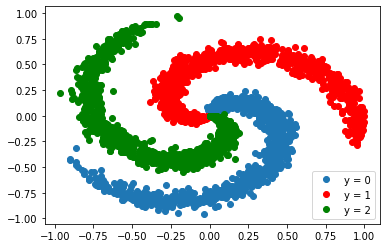

In [56]:
# Create a Dataset object

data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

In [57]:
train_loader = DataLoader(dataset=data_set, batch_size=100)

In [104]:
# The function to calculate the accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

In [145]:
arr = np.array([0.5])
arr2 = np.array([0.7])
arr_list = []
arr_list.append(arr)
arr_list.append(arr2)
total = sum(arr_list)/2
total

array([0.6])

In [153]:
# Define the train function

def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []

    results = {'loss':LOSS, 'acc':ACC}
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
      step = 0
      step_acc = []
      for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        results['loss'].append(loss.item())
        # get the hard indices of the predicted labels
        _, preds = torch.max(yhat, 1)
        step_acc.append((preds == y ).cpu().numpy().mean())
        step += 1
      results['acc'].append(sum(step_acc) / step)
      
      if (epoch+1) % 100 == 0:
        print(f'trained {epoch+1} epochs')

    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(results['loss'], color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(results['acc'], color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return results

trained 100 epochs
trained 200 epochs
trained 300 epochs
trained 400 epochs
trained 500 epochs
trained 600 epochs
trained 700 epochs
trained 800 epochs
trained 900 epochs
trained 1000 epochs


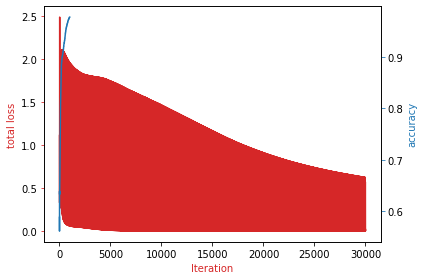

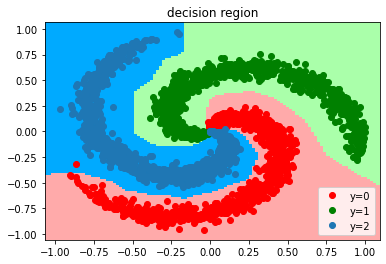

In [154]:
# Train the model with 1 hidden layer with 50 neurons

Layers = [2, 50, 3]
model = DNN(Layers)
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
results = train(data_set, model, criterion, train_loader, optimizer, epochs=1000)

plot_decision_regions_3class(model.cpu(), data_set)

trained 100 epochs
trained 200 epochs
trained 300 epochs
trained 400 epochs
trained 500 epochs
trained 600 epochs
trained 700 epochs
trained 800 epochs
trained 900 epochs
trained 1000 epochs


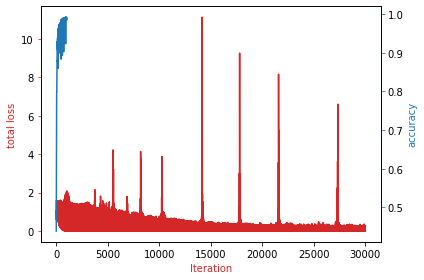

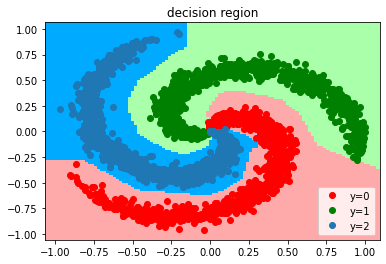

In [155]:
# Train the model with 3 hidden layer with 50, 100, 100 neurons respectively
# the multiple hidden layers DNN has better performance

Layers = [2, 50, 100, 100, 3]
model_h3 = DNN(Layers)
learning_rate = 0.05
optimizer = torch.optim.SGD(model_h3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
results = train(data_set, model_h3, criterion, train_loader, optimizer, epochs=1000)

plot_decision_regions_3class(model_h3.cpu(), data_set)